# Player Pass Map (StatsBomb)

This notebook implements **Part 1 – Visualization of a player's passes**

**Objective**  
Select a match and a player, and build a field diagram showing all passes made by that player in the match using StatsBomb event data and the `mplsoccer` library.

**Data source**

- Provider: **Hudl StatsBomb – Open Data**
- `competition_id = 16`
- `season_id = 1`
- `match_id = 18245`
- Match: **Real Madrid vs Liverpool FC**
- Player analysed: **Toni Kroos**







### Import necessary libraries

In [1]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mplsoccer import Pitch, Sbopen

### 1. Load competitions and matches using `Sbopen`

Select the match Real Madrid vs Liverpool FC (`match_id = 18245`).

In [2]:
# Load competitions, matches

parser = Sbopen()

# 1) List competitions
df_comp = parser.competition()
df_comp.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-09-28T20:46:38.893391,2025-07-06T04:26:07.636270,2025-07-06T04:26:07.636270,2024-09-28T20:46:38.893391
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-09-28T01:57:35.846538,None,None,2024-09-28T01:57:35.846538
3,16,4,Europe,Champions League,male,False,False,2018/2019,2025-05-08T15:10:50.835274,2021-06-13T16:17:31.694,None,2025-05-08T15:10:50.835274
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


### 2. Load all event data for this match with `parser.event(match_id)`.

In [3]:
# Get competition ID and season id and parse match

competition_id = 16
season_id = 1

# 2) Get match for that competition and season
df_match = parser.match(competition_id, season_id)
df_match[['competition_id', 'season_id', 'match_id', 'home_team_name', 'away_team_name']].head()

,competition_id,season_id,match_id,home_team_name,away_team_name
0,16,1,18245,Real Madrid,Liverpool


In [4]:
match_id = int(df_match.loc[0, 'match_id'])

# 3) Load event data
df_event, df_related, df_freeze, df_tactics = parser.event(match_id)
df_event.head()

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,pass_miscommunication,shot_one_on_one,block_offensive,shot_redirect,foul_committed_advantage,foul_won_advantage,pass_goal_assist,foul_committed_card_id,foul_committed_card_name,injury_stoppage_in_chain
0,5eee3ffd-f0c0-4532-868b-4a66cbf20cb8,1,1,00:00:00,0,0,1,0.000000,18245,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,eaa65a92-02d3-4375-b2b7-7c2f679a620c,2,1,00:00:00,0,0,1,0.000000,18245,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9c82d2e5-ebba-4825-b7f9-b11b04433ed8,3,1,00:00:00,0,0,1,0.000000,18245,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b791047a-3eea-452f-b3a9-212bd40cd7cb,4,1,00:00:00,0,0,1,0.000000,18245,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25be91a5-a084-42cb-8cc1-a0fe7b0f52f9,5,1,00:00:00.371000,0,0,2,1.735914,18245,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3. Filter the event data:
   - keep only events where `type_name == "Pass"`,
   - filter to passes made by Toni Kroos (`player_name == "Toni Kroos"`).

In [5]:
#Keep only passes
passes = df_event[df_event['type_name'] == 'Pass'].copy()

# See which players made passes
passes['player_name'].value_counts().head(20)

player_name
Toni Kroos                             92
Sergio Ramos García                    85
Marcelo Vieira da Silva Júnior         84
Luka Modrić                            72
Raphaël Varane                         62
José Ignacio Fernández Iglesias        53
Francisco Román Alarcón Suárez         50
Trent Alexander-Arnold                 44
Jordan Brian Henderson                 42
Andrew Robertson                       40
Karim Benzema                          39
Georginio Wijnaldum                    39
Carlos Henrique Casimiro               38
Cristiano Ronaldo dos Santos Aveiro    35
James Philip Milner                    35
Dejan Lovren                           33
Daniel Carvajal Ramos                  31
Roberto Firmino Barbosa de Oliveira    29
Virgil van Dijk                        29
Loris Karius                           28
Name: count, dtype: int64

In [6]:
# Pick specific player
player_name = 'Toni Kroos'
player_passes = passes[passes['player_name'] == player_name].copy()

### 4. Split these passes into:
   - **completed passes** (`outcome_name` is `NaN`),
   - **incomplete passes** (`outcome_name` not null).

In [19]:
# Completed vs incomplete
completed = player_passes[player_passes['outcome_name'].isna()].copy()
incomplete = player_passes[player_passes['outcome_name'].notna()].copy()

print("Total passes:", len(player_passes))
print("Completed passes:", len(completed))
print("Incomplete passes:", len(incomplete))

Total passes: 92
Completed passes: 84
Incomplete passes: 8


### 5. Plot all passes on a **StatsBomb pitch** using `mplsoccer.Pitch`:
   - dark background (`pitch_color = "#050816"`),
   - blue arrows for completed passes,
   - red arrows for incomplete passes,
   - legend explaining both categories.

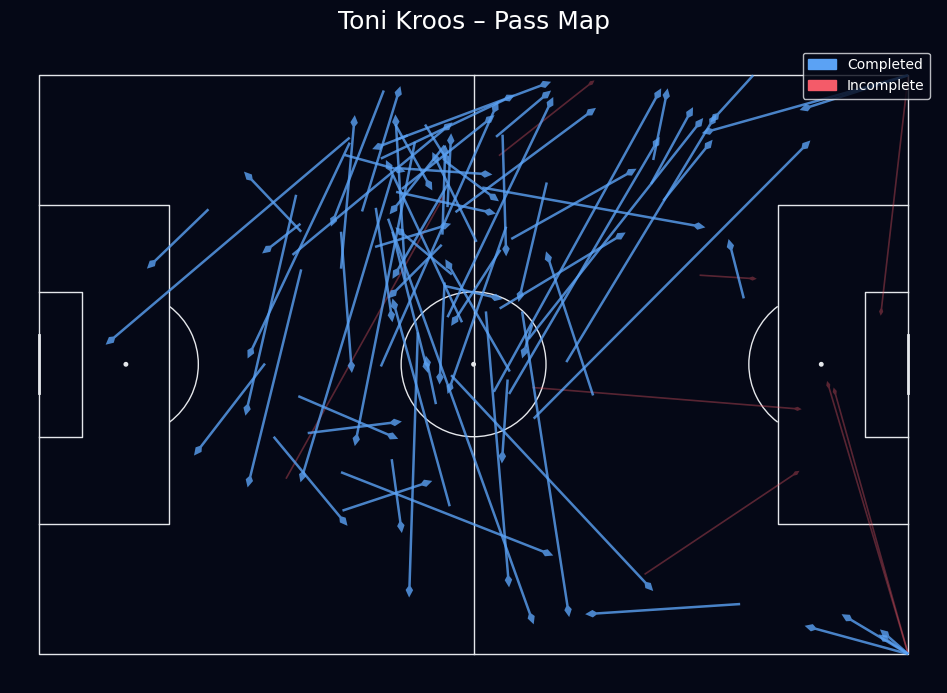

In [14]:
# Create pitch
pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color="#050816",
    line_color="#e5e7eb",
    linewidth=1.0
)

fig, ax = pitch.draw(figsize=(10, 7))
fig.set_facecolor("#050816")

# Plot passes
completed_color = "#5BA2F4"
incomplete_color = "#F45B69"

# Completed passes
pitch.arrows(
    completed["x"], completed["y"],
    completed["end_x"], completed["end_y"],
    ax=ax,
    color=completed_color,
    width=1.8,
    headwidth=3,
    headlength=3,
    alpha=0.8,
    zorder=3
)

# Incomplete passes
pitch.arrows(
    incomplete["x"], incomplete["y"],
    incomplete["end_x"], incomplete["end_y"],
    ax=ax,
    color=incomplete_color,
    width=1.2,
    headwidth=2.5,
    headlength=2.5,
    alpha=0.35,
    zorder=2
)

# Title & legend
player_name = player_passes["player_name"].iloc[0]

title_main = f"{player_name} – Pass Map"
ax.set_title(title_main, fontsize=18, color="white", pad=12)

# Legend
completed_patch = mpatches.Patch(color=completed_color, label="Completed")
incomplete_patch = mpatches.Patch(color=incomplete_color, label="Incomplete")
legend = ax.legend(
    handles=[completed_patch, incomplete_patch],
    loc="upper right",
    frameon=True,
    facecolor="#050816",
    edgecolor="#e5e7eb",
    labelcolor="white"
)

plt.tight_layout()
plt.show()

### Interpretation – Toni Kroos Pass Map (Real Madrid vs Liverpool FC)

This pass map shows all passes attempted by **Toni Kroos** for Real Madrid in the match against Liverpool FC (`competition_id = 16`, `season_id = 1`, `match_id = 18245`). Completed passes are drawn in blue and incomplete passes in red on a dark StatsBomb pitch.

Technical details:

- Only events labelled as `Pass` in the StatsBomb event data are included.
- Passes are split into completed vs incomplete using the `outcome_name` field.


From the map we can visually assess:

- The typical zones where Kroos receives and plays the ball (e.g. deeper central areas and half-spaces).
- The mix between shorter circulation passes and longer diagonal switches.
- Where his riskier, more ambitious actions occur (location of incomplete passes).

Overall, this visual provides an intuitive snapshot of Kroos’s distribution and involvement in Real Madrid’s possession during this specific match.
